In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#modules to find path of all sessions
import glob
import os
import numpy as np
import pickle
import platform
import math
from IPython.display import clear_output, display, HTML
from matplotlib.patches import Rectangle
from matplotlib import collections  as mc
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')

### you might need to change the line below if you want to regenerate the figure on a differente computer 
### Below we will run some preprocessing notebooks. In our case, our preprocessing notebooks are located in 
### a folder ("load_preprocess_mouse") which is at the same level that the folder that contain the notebooks 
### that generate the figures (for instance this one)


notebookPath=os.path.dirname(os.path.realpath("__file__"))
pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_mouse")
os.chdir(pathToProcessingNotebooks)   
%run loadMouse_documentation.ipynb
%run loadRawSpike_documentation.ipynb
%run plotMouse_Behavior.ipynb
#%run plotMouse_SpikingActvity.ipynb


#######

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

def cm2inch(value):
    return value/2.54
    

#Those parameters are overwritten if there is a .behav_param file
paramCarola={
    "distanceToRun":100,
    "maxTrialDuration": 60,
    "valveONTime":50,
    "minInterTrialDuration":15,
    "immobilityDuration":2,
    #to read .eeg (put None to not read .eeg)
    "nChannelElectro":32, #32
    "channel_opto": -6, #not used
    "channel_lickBreak":-5,
    "channel_reward": -4, #not used currently
    "channel_sound": -3, #not used
    "channel_trialON": -2,
    "channel_beamBreak": -1,
}    


#### root is the path to the folder where the data (MOUXXX, MOUXXY, ....ALLMOU_Analysis) are located
### you might need to change the line below depending on your computer orgnization


if platform.system()=='Linux':
    root="/data/DataCurrentBioPaper2018/"
else:
    root="/Users/davidrobbe/Documents/Data/"
    
    
# Where to save Files

savePath=os.path.join(root,"ALLMOU_Analysis","FigForMS")
    
print("path to data is %s"%root)
print("")
print("importing done")
#%run plotMouse_SpikingActivity.ipynb

path to data is /data/DataCurrentBioPaper2018/

importing done


In [3]:
%run plotMouse_SpikingActivity.ipynb

## Part I: For all the cells accross good sessions compute meanfiringrate during runs and find significant modulation portion
## <span style="color:red">Take ~ 10 min to run!</span> No need to rerun it each time: output are saved in pickle files

In [ ]:
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

#Whether to read the existing pickle files (redo=False) or to reload from raw text files (redo=True)
redo = False
###############################
redo = False
###############################
#Wheter to run some batch on electrophy data
runElectrophyBatch=True
###############################
runElectrophyBatch=True
###############################
#list of tags (tag = empty file in the session folder with a specific name)
#leave empty for no tag
tagList = ["GoodPerfo"]
###############################

###############################

#---------------------------------------------------------------------------
print("List of animal to loop through: %s" % animalList)
print("Tag list: %s" % tagList)

#loop on animal
animalindex=1
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    
    
    #loop through sessions
    for index, session in enumerate(sessionList):
        
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
        
        #print("Session %s/%s: %s"%(index+1,nbSession,session))
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        
        sessionData=Data(root, animal, session, param=paramCarola, redoPreprocess=redo)
            

        
        if runElectrophyBatch:


            print("Session %s is beeing analyzed with  GetAllSignificantModulation function"%session)
            GetAllSignificantModulation(sessionData,redo=True,saveAsPickle=True,excludeDrift=True,behaviorType=["Runs","all"])


clear_output()
print("Done")


## Loop through session/cells and load tuning curves.
## Calculate the mean duration of the run epochs for all the units accross sessions to normalize run duration accross session. Normalize the tuning curves durations

In [4]:
behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
#list of all animals
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
totalneurons=0
totalposmod=0
totalnegmod=0

### loop throught the session to find the length of average firing rate for the different sessions


averageRunDurationAccrossAllUnits=[]



#loop on animal
for animal in animalList:

    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)   

    #loop through sessions and load pickle file
    for index,session in enumerate(sessionList):


        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                           
        
        
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        firingRatesModulation=pickle.load(open(picklePath,"rb"))
        
        
        for shank in firingRatesModulation["MeanFiringRateZscored"]:
            for cluster in firingRatesModulation["MeanFiringRateZscored"][shank]:
                totalneurons+=1
                if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                    averageRunDurationAccrossAllUnits.append(len(firingRatesModulation["insideBehaviorIndexes"][shank][cluster]))
                    if firingRatesModulation["BiggestModulationSign"][shank][cluster]=="positive":
                        totalposmod+=1
                    else:
                        totalnegmod+=1
                
                
nSideBin=firingRatesModulation["insideBehaviorIndexes"][shank][cluster][0]
medianAverageRunDurationAccrossAllUnits=np.median(averageRunDurationAccrossAllUnits)
print("median duration of runs %s" %medianAverageRunDurationAccrossAllUnits)
print("total number of unit analyzed: %i" %totalneurons)
print("number of modulated units %s" %(len(averageRunDurationAccrossAllUnits)))
print("percent positvely modulated: %i" %(totalposmod/totalneurons*100))
print("percent negatively modulated: %i" %(totalnegmod/totalneurons*100))


median duration of runs 28.0
total number of unit analyzed: 154
number of modulated units 134
percent positvely modulated: 72
percent negatively modulated: 14


median duration of runs 28.0

total number of unit analyzed: 167

number of modulated units 146

percent positvely modulated: 72

percent negatively modulated: 14

In [4]:
def normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes):
    
    meanFiringRateInRun=thisFiringRateModulation[insideRunBins]
    runIndexes=range(len(meanFiringRateInRun))
    runIndexesInterp=np.arange(0,float(runIndexes[-1])+float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1),float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1))
    if len(runIndexesInterp)>medianAverageRunDurationAccrossAllUnits:
        runIndexesInterp=np.asarray([x for x in runIndexesInterp if x <= float(runIndexes[-1])])

    # do the itnerpolation
    meanFiringRateInRunNorm=np.interp(runIndexesInterp,runIndexes,meanFiringRateInRun)
    # reconcatenate the borders
    normFiringRateInRun=np.concatenate([thisFiringRateModulation[0:insideRunBins[0]],meanFiringRateInRunNorm,thisFiringRateModulation[insideRunBins[-1]+1:]],axis=0)

    
    # find the significant modulation on time normalized data
    allIndexes=list(range(len(thisFiringRateModulation)));
    allIndexesInterpt=np.concatenate([allIndexes[:insideRunBins[0]],runIndexesInterp+insideRunBins[0],allIndexes[-insideRunBins[0]:]],axis=0)
    
    #Get the border of the modulation
    borders=contiguous_regions(np.asarray([X in signifiantModulationIndexes for X in allIndexes])).tolist()
    interpolatedSignificantIndexes=[]
    for startstop in borders:
        interpolatedSignificantIndexes.append([index for index,value in enumerate(allIndexesInterpt) if (value>=startstop[0] and value<=startstop[1])])
    
    return normFiringRateInRun,interpolatedSignificantIndexes
    
    
    
    

# loop across data to normalize length of mean firing rate across session
# keep cells that have a modulation sign according to TargetString

#animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
allFiringRates=[]
nberOfPositivelyModulatedCells=0
nberOfNegativelyModulatedCells=0
for animal in animalList:


    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    
  

    #loop through sessions
    for index,session in enumerate(sessionList):
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        if os.path.exists(picklePath):
            #print(picklePath)
            firingRatesModulation=pickle.load(open(picklePath,"rb"))
            
            for shank in firingRatesModulation["MeanFiringRate"]:
                for cluster in firingRatesModulation["MeanFiringRate"][shank]:
                    if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                        insideRunBins=firingRatesModulation['insideBehaviorIndexes'][shank][cluster]
                        thisFiringRateModulation=firingRatesModulation["MeanFiringRate"][shank][cluster]
                        signifiantModulationIndexes=firingRatesModulation["AllSignificantModulationIndexInBehaviorSameSignThanBiggest"][shank][cluster]
                        normFiringRateInRun,interpolatedSignificantIndexes=normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes)
                           
                        
                        #find max or min and append main variables in a big list
                        if firingRatesModulation["BiggestModulationSign"][shank][cluster]=='positive':
                            strongestModulationIndex=np.argmax(normFiringRateInRun)
                            nberOfPositivelyModulatedCells+=1

                        elif firingRatesModulation["BiggestModulationSign"][shank][cluster]=='negative':
                            strongestModulationIndex=np.argmin(normFiringRateInRun)
                            nberOfNegativelyModulatedCells+=1
                            
                        allFiringRates.append([strongestModulationIndex,normFiringRateInRun,interpolatedSignificantIndexes,session,shank,cluster,firingRatesModulation["BiggestModulationSign"][shank][cluster]])

firingRatesAs2DArray=np.asarray([item[1] for item in allFiringRates])
# NormFiringRatesAs2DArray=np.asarray([item[1]/max(item[1]) for item in allFiringRates])
# generate an array with just the significative positive modulation

allFiringRatesPositiveModulation=[firingRate for firingRate in allFiringRates if firingRate[-1]=='positive']
timeSortedFiringRatesPositiveModulation=sorted(allFiringRatesPositiveModulation, key=lambda firingdata: firingdata[0])
#timeSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in timeSortedFiringRatesPositiveModulation])
#NonSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in allFiringRatesPositiveModulation])

In [5]:
def plot_distribution(rawdata,maxminstep,xyLabels=["N","Bins"]):   
    plt.hist(rawdata,np.arange(maxminstep[0],maxminstep[1]+maxminstep[2],maxminstep[2]),width=maxminstep[2]*1,color='k',linewidth=0)
    ax = plt.gca()
    #ax.set_xlim(maxminstep[:2])
    ax.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax.set_xlabel(xyLabels[1],fontsize=12,labelpad=0
                 )
    ax.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.get_xaxis().set_tick_params(direction='out',pad=1)
    ax.get_yaxis().set_tick_params(direction='in',pad=2)
    
    return ax

In [6]:
def plotallcells(sortedNormFiringRatesAs2DArray,nSideBin=12,showXlabel=True,ylabel="Units"):
    
    
    plt.imshow(sortedNormFiringRatesAs2DArray,interpolation="bilinear",aspect="auto",origin="low",cmap="Reds")
    
    #plt.pcolormesh(timebin,y,sortedNormFiringRatesAs2DArray,cmap="Reds")
    ax = plt.gca()
    #plt.xlim(0,timebin[-1])
    ax.set_ylim([0,sortedNormFiringRatesAs2DArray.shape[0]])
    ax.tick_params(axis='both',which='major',width=1)
    ax.set_ylabel(ylabel,fontsize=12)
    ax.set_yticks(np.arange(0,sortedNormFiringRatesAs2DArray.shape[0],20))
    ax.yaxis.set_label_coords(-0.15,0.5)
    
    if showXlabel:    
        ax.set_xlabel("Run phase",fontsize=12)
        ax.set_xticklabels(["start","","stop"])
    else:
        ax.set_xticklabels([])
    
    ax.axvline(nSideBin,color="orange",linestyle='--',linewidth=3,alpha=0.7)
    ax.axvline( sortedNormFiringRatesAs2DArray.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=3,alpha=0.7)
    #ax = plt.gca()   
    ax.set_xticks([nSideBin,sortedNormFiringRatesAs2DArray.shape[1]/2,sortedNormFiringRatesAs2DArray.shape[1]-nSideBin])
    ax.get_xaxis().set_tick_params(direction='in',pad=2)
    ax.get_yaxis().set_tick_params(direction='in',pad=2)
    
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.tick_top()
    ax.tick_params(labelbottom='off',labeltop='on')
    ax.xaxis.set_label_position('top')
#     ax.tick_params(labelbottom='on',labeltop='off')
#     ax.xaxis.set_label_position('bottom')
#     ax.xaxis.set_label_coords(0.5,-0.31)

In [7]:
def plot_SessionPerfoAndSpikeTryByTrialForFig(data,shank,cluster,legend=False,colorOpto="orange",xmax=60,ax=None,lick=False,ThisYLim=None,showYLabel=True,showXLabel=True):  
    if ax is None:
        ax = plt.gca()
    minTime= - max(data.durationTrial)
    maxTime= max(data.durationInterTrial)
    maxTime=min(xmax,maxTime)
    distanceToRun=data.distanceToRun[0]
    wheelLines=[]
    lickLines=[]
    rewardLines=[]
    #ticks where the distance to run has changed
    boldTicks={1:distanceToRun}
    
    for trial in data.trials:
        y1=trial+1.1
        y2=trial+1.1
        y3=trial+1.6
        y4=trial+1.9
        

        
        #we want to align the plot on the trial end (=reward =start of intertrial)
        zero=data.durationTrial[trial]
        if zero < 60:
            rewardLines.append([(0,trial+1.1),(0,trial+1.6)]) 
        
        #trial beam break time are relative to trial start
        for breakTime in data.beamBreakTime[trial]:
            x=breakTime-zero
            wheelLines.append([(x,y1),(x,y4)])
            
        #intertrial beam break time are already aligned correctly
        for x in data.beamBreakTime[trial+0.5]:
            wheelLines.append([(x,y1),(x,y4)])
            
        #if there is lick break times
        if (len(data.lickBreakTime)>0) and lick:
            for lickTime in data.lickBreakTime[trial]:
                x=lickTime-zero
                lickLines.append([(x,y2),(x,y3)])
            for x in data.lickBreakTime[trial+0.5]:
                lickLines.append([(x,y2),(x,y3)])
            
        #color in grey the duration of trial and intertrial
        endInterTrial=data.durationInterTrial[trial]
        ax.add_patch(Rectangle((-zero,trial+1), zero, 1, facecolor="lightgrey",edgecolor="none",zorder=-3))
        ax.add_patch(Rectangle((0,trial+1), endInterTrial, 1, facecolor="lavender",edgecolor="none",zorder=-3))
        #green square when 2 s immobility OK
        ax.add_patch(Rectangle((endInterTrial-2,trial+1.1), 2, 0.8, facecolor="none",edgecolor="limegreen",lw=0.5))
        #red square when 2 s immobility KO
        if data.durationInterTrial[trial]>data.minInterTrialDuration[trial]:
            ax.add_patch(Rectangle((data.minInterTrialDuration[trial]-2,trial+1.1), 2, 0.8, facecolor="none",edgecolor="red",lw=0.5))
                
    
        #Plot all the lines trial by trial
    lc = mc.LineCollection(wheelLines,colors="black",linewidths=0.5,zorder=-2)
    lc2= mc.LineCollection(lickLines,colors="blue",linewidths=0.5,zorder=-1)
    lc3= mc.LineCollection(rewardLines,colors="aqua",linewidths=1,zorder=-1)
    ax.add_collection(lc)
    ax.add_collection(lc2)
    ax.add_collection(lc3)   
    
    #bold ticks
    space=10
    rangeList=list(set(range(10,data.nTrial+2,space)).union(boldTicks))
    ticksPosition=[y+0.5 for y in rangeList]
    #ticksLabel=[str(boldTicks[y])+"cm| "+str(y) if y in boldTicks else str(y) for y in rangeList]
    ticksLabel=[str(y) if y in boldTicks else str(y) for y in rangeList] 
    
    ax.tick_params(axis='y',which='both',labelsize=10,direction='in',length=3)
    ax.locator_params(axis='x',nbins=3)
    ax.tick_params(axis='x',which='major',labelsize=10,direction='out',length=3,pad=1)
    
    #     ax.tick_params(axis='both',which='major',labelsize=10,direction='in')
    ax.set_yticks(ticksPosition,ticksLabel)
    
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    #axis limits
    ax.set_xlim([-10,4])
    ax.invert_yaxis()
    if ThisYLim is None:
        ax.set_ylim([data.realTrials[-1]+1,data.realTrials[0]])
    else:
        ax.set_ylim([ThisYLim,data.realTrials[0]])
    
    #plot the spikes
    
    lines=[]   
    cluSpike=data.spikeTime[shank][cluster]
    for trial in data.trials:
        start=data.realStartTrial[trial]
        zero=start+data.durationTrial[trial]
        stop=zero+data.durationInterTrial[trial]
        trialSpikes=cluSpike[(cluSpike>start)&(cluSpike<stop)]-zero
        for spike in trialSpikes:
            lines.append([(spike,trial+1.1),(spike,trial+1.5)])
      
    lc= mc.LineCollection(lines,colors="red",label="spikes of shank %s cluster %s"%(shank,cluster),linewidths=0.5,zorder=1)
    ax.add_collection(lc)
    
    if showYLabel:
        ax.set_ylabel("First %s trials" %ThisYLim,fontsize=12)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_label_coords(-0.05,0.5)
    else:
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        
        
    if showXLabel:
        ax.set_xlabel("Time (s)",fontsize=12,labelpad=0)
#         ax.xaxis.set_label_coords(0.5,-0.23)

    
    


In [8]:
def plot_SessionPerfoTryByTrialForFig(data,legend=False,xmax=60,ax=None,lick=True,ThisYLim=None,showYLabel=True):  
    
    if ax is None:
        ax = plt.gca()
    minTime= - max(data.durationTrial)
    maxTime= max(data.durationInterTrial)
    maxTime=min(xmax,maxTime)
    distanceToRun=data.distanceToRun[0]
    wheelLines=[]
    lickLines=[]
    rewardLines=[]
    
    #ticks where the distance to run has changed
    boldTicks={1:distanceToRun}
    
    for trial in data.trials:
        y1=trial+1.1
        y2=trial+1.1
        y3=trial+1.6
        y4=trial+1.9
        

        
        #we want to align the plot on the trial end (=reward =start of intertrial)
        zero=data.durationTrial[trial]
        if zero < 60:
            rewardLines.append([(0,trial+1.1),(0,trial+1.6)]) 
        
        #trial beam break time are relative to trial start
        for breakTime in data.beamBreakTime[trial]:
            x=breakTime-zero
            wheelLines.append([(x,y1),(x,y4)])
            
        #intertrial beam break time are already aligned correctly
        for x in data.beamBreakTime[trial+0.5]:
            wheelLines.append([(x,y1),(x,y4)])
            
        #if there is lick break times
        if (len(data.lickBreakTime)>0) and lick:
            for lickTime in data.lickBreakTime[trial]:
                x=lickTime-zero
                lickLines.append([(x,y2),(x,y3)])
            for x in data.lickBreakTime[trial+0.5]:
                lickLines.append([(x,y2),(x,y3)])
            
        #color in grey the duration of trial and intertrial
        endInterTrial=data.durationInterTrial[trial]
        ax.add_patch(Rectangle((-zero,trial+1), zero, 1, facecolor="lightgrey",edgecolor="none",zorder=-3))
        ax.add_patch(Rectangle((0,trial+1), endInterTrial, 1, facecolor="lavender",edgecolor="none",zorder=-3))
        #green square when 2 s immobility OK
        ax.add_patch(Rectangle((endInterTrial-2,trial+1.1), 2, 0.8, facecolor="none",edgecolor="limegreen",lw=0.5))
        #red square when 2 s immobility KO
        if data.durationInterTrial[trial]>data.minInterTrialDuration[trial]:
            ax.add_patch(Rectangle((data.minInterTrialDuration[trial]-2,trial+1.1), 2, 0.8, facecolor="none",edgecolor="red",lw=0.5))
                
    
        #Plot all the lines trial by trial
    lc = mc.LineCollection(wheelLines,colors="black",linewidths=0.5,zorder=-2)
    lc2= mc.LineCollection(lickLines,colors="blue",linewidths=0.5,zorder=-1)
    lc3= mc.LineCollection(rewardLines,colors="aqua",linewidths=1,zorder=-1)
    ax.add_collection(lc)
    ax.add_collection(lc2)
    ax.add_collection(lc3)   
    
    #bold ticks
    space=10
    rangeList=list(set(range(10,data.nTrial+2,space)).union(boldTicks))
    ticksPosition=[y+0.5 for y in rangeList]
    #ticksLabel=[str(boldTicks[y])+"cm| "+str(y) if y in boldTicks else str(y) for y in rangeList]
    ticksLabel=[str(y) if y in boldTicks else str(y) for y in rangeList] 
    plt.yticks(ticksPosition,ticksLabel)
    ax.tick_params(axis='both',which='major',labelsize=10,direction='in',length=3)
    

    
    
    #axis limits
    ax.set_xlim([-xmax,40])
    ax.invert_yaxis()
    if ThisYLim is None:
        ax.set_ylim([data.realTrials[-1]+1,data.realTrials[0]])
    else:
        ax.set_ylim([ThisYLim,data.realTrials[0]])
    
    
    #axis labels and title
    #plt.xlabel("Time (s), 0=trial end",fontsize=30,weight="bold")
    if showYLabel:
        ax.set_ylabel("First %s trials" %ThisYLim,fontsize=12)     
    else:
        ax.yaxis.set_ticklabels([])
    
    ax.set_xlabel("Time (s)",fontsize=12,labelpad=0)
#     ax.xaxis.set_label_coords(0.5,-0.23)
    
    ax.locator_params(axis='x',nbins=3)
    xticks = ax.xaxis.get_major_ticks()
    xticks[-1].label1.set_visible(False)
    ax.tick_params(axis='x',direction='out',pad=1,length=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    title=data.experiment+" (day "+str(data.daySinceStart)+")\nBeam and lick break time"
    if data.hasOptogenetic:
        title+="\n %s"%data.stimulationNames
    #plt.title(title,fontsize=14)
    
    #legend with no duplicate
    if legend:
        plt.plot([], [], linewidth=6,color='lightgrey', label="trial time range")
        plt.plot([], [], linewidth=6,color='lavender', label="intertrial time range")
        plt.legend(loc='best', bbox_to_anchor=(1, 1))
    return title

    handles, labels = plt.get_legend_handles_labels()
    lgd = plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))
    plt.tight_layout()
              

In [9]:
def check_period_detectionForFig(data, start, end):
    # in the orginal code of thyphaine there is a bug caused by the fact that the last trial has no intetrial
    #this caused wrong detection of a good trial as overlappping intetrial and trial and premature break out of the program
    #this corrected by using the time of the last wheel detection as time for the end of intertrial periode 
    plot_SessionPerfoTryByTrialForFig(data, legend=False,lick=False,ThisYLim=35,showYLabel=False)
    
    ax = plt.gca()
    
    trialStart = data.realStartTrial[0]
    trial = 0
    zero = data.durationTrial[0]
    trialEnd = trialStart + zero + data.durationInterTrial[trial]    
#     print("trialStart: %s, zero: %s, trialEnd: %s" %(trialStart, zero+trialStart,trialEnd))

    loop=0
    for s, e in zip(start, end):
        loop+=1
#         print("loop: %s" %loop)
#         print("s: %s, e: %s" %(s,e))
        if s <= trialStart:
#             print("first case is used")
#             print("trial number: %s" %trial)
#             print("trialStart: %s, zero: %s, trialEnd: %s" %(trialStart, zero+trialStart,trialEnd))         
             continue
        while s >= trialEnd:
            trial += 1
            #print("detected run number %s occurs during trial nber: %s" %(loop,trial+1))
            if trial+1 > data.nTrial:
                break
            
            zero = data.durationTrial[trial]
            trialStart = trialEnd
            if (trial+1==data.nTrial) and (data.durationInterTrial[trial]==0):
                #print("last trial!!!")
                trialEnd = data.allBeamBreak[-1]+1
            else:
                trialEnd += zero + data.durationInterTrial[trial]
            
        if s <= trialEnd and e >= trialEnd:
#             print("trialStart: %s, zero: %s, trialEnd: %s" %(trialStart, zero+trialStart,trialEnd)) 
#             print("third case is used")
#             print("duration intertrial: %s" %data.durationInterTrial[trial])
#             print("trial nber: %s" %(trial+1))
            while e >= trialEnd:
                #period is in beween two trials
                startRec = s - trialStart - zero
                length = data.durationInterTrial[trial] - startRec
                #ax.add_patch(Rectangle((startRec, trial+1), length, 0.8, facecolor="lightcoral", edgecolor="none"))              
                if trial+2 > data.nTrial:
                    break                
                length2 = min(e-s-length, data.durationTrial[trial+1]+data.durationInterTrial[trial+1])                
                ax.add_patch(Rectangle((-data.durationTrial[trial+1], trial+2), length2, 0.8, facecolor="none", 
                                       edgecolor="orange",zorder=0,linewidth=0.5,linestyle="-"))
                trial += 1
                zero = data.durationTrial[trial]
                trialStart = trialEnd
                #trialEnd += zero + data.durationInterTrial[trial]
                if (trial+1==data.nTrial) and (data.durationInterTrial[trial]==0):
                    #print("last trial!!!")
                    trialEnd = data.allBeamBreak[-1]+1
                else:
                    trialEnd += zero + data.durationInterTrial[trial]
                    
        else:
            ax.add_patch(Rectangle((s - trialStart - zero, trial+1), e-s, 1, facecolor="none", edgecolor="orange",zorder=0,linewidth=0.5,linestyle="-"))

    ax.set_xlim([-20,30])
            


def plot_normalized_running_periods_firing_rate_FORFIG(data, shank, cluster, binSize=0.25, minDuration=3, 
                                                maxDuration=15, SideLength=3, sigma=1, runType="trial good run", ax=None,VariableToPlot="FiringRate",showYLabel=True,showXLabel=True):
    
    return plot_normalized_periods_firing_rateFORFIG(data, shank, cluster, binSize=binSize, minDuration=minDuration, 
                                               maxDuration=maxDuration, SideLength=SideLength, sigma=sigma,
                                               periodType=runType, ax=ax, immobility=False, runMinDuration=None,VariableToPlot=VariableToPlot,showYLabel=showYLabel,showXLabel=showXLabel)


#---------------------------------------------------------------------------------------------------------------
def plot_normalized_periods_firing_rateFORFIG(data, shank, cluster, binSize=0.25, minDuration=3, maxDuration=15, SideLength=3,
                                        sigma=1, periodType="all", immobility=False, runMinDuration=0.1, ax=None,VariableToPlot="FiringRate",showYLabel=True,showXLabel=True):
    """
    Takes all running/immobility periods between minDuration seconds and maxDuration seconds
    Computes the mean running/immobility period duration, and divide it by binSize to get the number of bins
    For each running/immobility period, compute the speed given the number of bins, as well as the firing rate
    Plots the mean of the speeds and the mean of the firing rates.
    Before and after the running/immobility periods, nSideBin are also plotted.
    Input:
      - data, shank, cluster 
      - binSize, in seconds
      - minDuration, minimum duration of a period
      - maxDuration, maximum duration of a period
      - nSideBin, number of bins to consider before and after the period
      - sigma, parameter for the gaussian smoothing of the firing rate 
      - periodType, to specify a type of period
           for the runs: "trial good run", "trial bad run", "intertrial"
           for the immobility: "trial", "intertrial"
      - immobility, whether to plot immobility periods or running periods
      - runMinDuration, parameter for immobility period detection 
        (a run of less than runMinDuration is considered to be an immobility)
      - ax, matplotlib figure axe where to plot, useful when doing complex subplots
    """
                                              
                                              
    if ax is None:
        ax = plt.gca()     
    #spikes
    cluSpike = data.spikeTime[shank][cluster]
    
    if immobility:
        #immobility periods
        startPeriod, endPeriod, indexes = detect_immobility_period(data, minDuration, maxDuration, periodType,
                                                                   runMinDuration)
        runOrImmobile = "immobility"
    else:
        #running periods
        startPeriod, endPeriod, indexes = detect_running_period(data, minDuration, maxDuration, periodType)
        runOrImmobile = "running"
    
    #Detect number of bins based on mean duration and binsize
    allDuration = np.asarray(endPeriod) - np.asarray(startPeriod)
    meanDuration = np.nanmean(allDuration)
    nBins = np.ceil(meanDuration/float(binSize))    
    
    nSideBin=int(np.round(SideLength/binSize)) 
    #mean speed and firing rate in the bins
    allSpeed = []
    spikeHist = []
    rDuration = []
    for start, stop, duration in zip(startPeriod, endPeriod, allDuration):
        _bin = duration/float(nBins)
        rStart = start - (nSideBin+1) * _bin
        rStop = stop+ (nSideBin+1)*_bin - stop%_bin
        timeBin = np.arange(rStart, rStop+_bin, _bin)        
        hist, bins = np.histogram(data.allBeamBreak, timeBin)
        allSpeed.append(hist*data.tickDistance/float(_bin))
        hist, bins = np.histogram(cluSpike, timeBin)
        spikeHist.append(hist/float(_bin))
        rDuration.append(rStop-rStart)
        
    #compute the means and smooth
    meanDuration = np.nanmean(allDuration)
    meanSpeed = np.nanmean(np.asarray(allSpeed), axis=0)
    
    #smoothing of the running speed must be splitted in 3. Before, during and after run
    #meanSpeed = smooth(meanSpeed, sigma)
    meanSpeed[0:nSideBin]=smooth(meanSpeed[0:nSideBin],sigma)
    meanSpeed[nSideBin:len(meanSpeed)-nSideBin]=smooth(meanSpeed[nSideBin:len(meanSpeed)-nSideBin],sigma)
    meanSpeed[len(meanSpeed)-nSideBin:]=smooth(meanSpeed[len(meanSpeed)-nSideBin:],sigma)
    
    
    meanFiring = np.nanmean(np.asarray(spikeHist), axis=0)
    meanFiring = smooth(meanFiring, sigma)
    
    xmax = nBins + (nSideBin+1) * 2
    xaxis = np.arange(0.5, xmax, 1)
    #plot speed
    if VariableToPlot=="FiringRate":
        ax.plot(xaxis, meanFiring, color="red",linewidth=2) 
        #plt.ylim([0,max(meanFiring)])
        if showYLabel:
            ax.set_ylabel("FRate (Hz)", fontsize=12,color='red',labelpad=0)
#             ax.yaxis.set_label_coords(-0.17,0.5)
    else:
        ax.plot(xaxis, meanSpeed, color="black",linewidth=2)
        ax.set_ylabel("Running\n speed (cm/s)", fontsize=12)
        
    if showXLabel:
            ax.set_xlabel("Run phase", fontsize=12,labelpad=0)
#             ax.xaxis.set_label_coords(0.5,-0.15)
        

    
    plt.axvspan(nSideBin, len(meanFiring)-nSideBin, facecolor="orange",edgecolor="none",alpha=0.5)

    
    ax.set_xlim([0, xmax])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xticks([nSideBin,len(meanSpeed)/2,len(meanSpeed)-nSideBin])
    #ax.get_xaxis().set_tick_params(direction='out')
    ax.set_xticklabels(["start","","stop"])
    ax.tick_params(axis='both', pad=1)
    
    ax.locator_params(axis='y',nbins=4)
    #ax.xaxis.set_major_locator[12,40]
    
    return ax, meanFiring, nSideBin, spikeHist, meanSpeed, allDuration

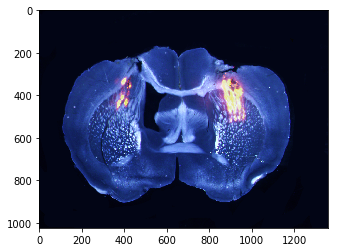

In [10]:
pathPicFileName=os.path.join(root,"ALLMOU_Analysis","HistoMOU","MOU121_Hist001.tif")
im = plt.imread(pathPicFileName)
plt.imshow(im)

In [11]:
topVSpace=0.05
bellowVSpace=0.075
leftHSpace=0.12
rightHSpace=0.99
betweenRowSpace=0.1
nRows=3 ## this is the number of figure block in the row dimension
ratioRows=[1,1,1]
vspaceForFig=1.0-(topVSpace+bellowVSpace+betweenRowSpace*(nRows-1))
#print("Total vertical space for figures: %s" %vspaceForFig)
topBottomLimits=[]
top=1
bottom=1
for rawNumber,rawRatio in enumerate(ratioRows):
    vSpaceForRow=vspaceForFig*(rawRatio/np.sum(ratioRows))
    print("raw %s size is %s" %(rawNumber+1, vSpaceForRow))
    if rawNumber==0:
        top-=topVSpace
        bottom-=topVSpace+vSpaceForRow
        print(top,bottom)
    else:
        top=bottom-betweenRowSpace
        bottom=top-vSpaceForRow
        print(top,bottom)
        print(rawNumber)
        if rawNumber==nRows-1:
            if np.round(bottom,2)!=np.round(bellowVSpace,2):
                print("last bottom does not match with required space")
    topBottomLimits.append([top,bottom])
print(topBottomLimits) 

raw 1 size is 0.225
0.95 0.725
raw 2 size is 0.225
0.625 0.4
1
raw 3 size is 0.225
0.30000000000000004 0.07500000000000004
2
[[0.95, 0.725], [0.625, 0.4], [0.30000000000000004, 0.07500000000000004]]


In [12]:
fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(12)))

for index,topBottomLimit in enumerate(topBottomLimits):
    if index==0:
        gs1=gridspec.GridSpec(1,4)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=0.76, wspace=0.16,hspace=0.5)
        ax1=plt.subplot(gs1[0])
        ax2=plt.subplot(gs1[1])
        ax3=plt.subplot(gs1[2])
        ax4=plt.subplot(gs1[3])
        
    elif index==1:
        gs1 = gridspec.GridSpec(1,4)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=0.76, wspace=0.16,hspace=0.5)
        ax1=plt.subplot(gs1[0])
        ax2=plt.subplot(gs1[1])
        ax3=plt.subplot(gs1[2])
        ax4=plt.subplot(gs1[3])
    else:
        gs1 = gridspec.GridSpec(1,4)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=0.76, wspace=0.16,hspace=0.5)
        ax1=plt.subplot(gs1[0])
        ax2=plt.subplot(gs1[1])
        ax3=plt.subplot(gs1[2])
        ax4=plt.subplot(gs1[3])

gs2 = gridspec.GridSpec(2,1,height_ratios=[nberOfPositivelyModulatedCells, nberOfNegativelyModulatedCells],hspace=0.05)
gs2.update(bottom=0.4,top=0.9,left=0.8,right=0.995)
ax1=plt.subplot(gs2[0])
ax2=plt.subplot(gs2[1])

gs3 = gridspec.GridSpec(1, 1)
gs3.update(bottom=0.1,top=0.35,left=0.8,right=0.995)
ax3=plt.subplot(gs3[0])


## Generate the figure

Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preproces

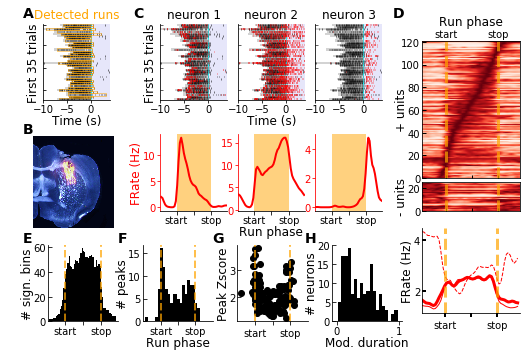

In [13]:
fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(12)))

illustrationCells=[["MOU101_2016_01_21_16_41",3,47],["MOU101_2016_01_21_16_41",3,53],["MOU101_2016_01_21_16_41",3,34]]
showXLabelBool=[False,True,False]
allMeanFiringRate=[]



for index,topBottomLimit in enumerate(topBottomLimits):
    if index==0:
        gs1=gridspec.GridSpec(1,4)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=0.72, wspace=0.16,hspace=0.5)
        

        ## illustrative units
        showYLabels=[True,False,False]
        subplotindex=1
        for showXLabel,showYLabel,illustrationCell in zip(showXLabelBool,showYLabels,illustrationCells):
            ANIMAL=illustrationCell[0][0:6]
            data=Data(root,ANIMAL,illustrationCell[0],paramCarola,redoPreprocess=False)
            ax=plt.subplot(gs1[subplotindex]) 
            plot_SessionPerfoAndSpikeTryByTrialForFig(data,illustrationCell[1],illustrationCell[2],xmax=10,legend=False,lick=False,ThisYLim=35,showYLabel=showYLabel,showXLabel=showXLabel)
            ax.set_title("neuron %s" %(subplotindex))
#             pos1 = ax.get_position() # get the original position 
#             pos2 = [pos1.x0-0.05, pos1.y0,  pos1.width, pos1.height]
#             ax.set_position(pos2)
            
            subplotindex += 1
            

        ## Detection of run
        start, end, indexes = detect_running_period(data, minDurationSecond=2, runType="trial good run",maxTimeBetweenBreak=1,maxDurationSecond=12)
        ax=plt.subplot(gs1[0])
        check_period_detectionForFig(data, start, end)
        ax.set_title("Detected runs",color='orange')
        ax.set_ylabel("First 35 trials",fontsize=12)
        ax.yaxis.set_label_coords(-0.05,0.5)
        ax.set_xlim([-10,4])
        pos1 = ax.get_position() # get the original position 
        pos2 = [pos1.x0-0.08, pos1.y0,  pos1.width, pos1.height]
        ax.set_position(pos2)
    
    ## second raw of figure
    elif index==1:
        gs1 = gridspec.GridSpec(1,4)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=0.72, wspace=0.16,hspace=0.5)
        
        
        ## insert histology
        pathPicFileName=os.path.join(root,"ALLMOU_Analysis","HistoMOU","MOU121_Hist001.tif")
        ax0=plt.subplot(gs1[0])
        im = plt.imread(pathPicFileName)
        ax0.imshow(im)
        ax0.set_xlim(xmin=600,xmax=1300)
        ax0.set_ylim(ymin=900,ymax=100)
        pos1 = ax0.get_position() # get the original position 
        pos2 = [pos1.x0-0.1, pos1.y0-0.05,  pos1.width*1.2, pos1.height*1.2]
        ax0.set_position(pos2)
        ax0.axis("off")
        
        
         # plot mean firing rate illustrative neurons
        showYLabel=[True,False,False]
        for index,illustrationCell in enumerate(illustrationCells):
            ANIMAL=illustrationCell[0][0:6]
            data=Data(root,ANIMAL,illustrationCell[0],paramCarola,redoPreprocess=False)    
            ax=plt.subplot(gs1[index+1])
            thisMeanFiringRate=plot_normalized_running_periods_firing_rate_FORFIG(data,illustrationCell[1],illustrationCell[2], binSize=0.25,runType="trial good run",VariableToPlot="FiringRate",showYLabel=showYLabel[index],showXLabel=showXLabelBool[index])[1]
            allMeanFiringRate.append(thisMeanFiringRate)
            ax.spines['left'].set_color('red')
            ax.tick_params(axis='y',colors='red')
#             pos1 = ax.get_position() # get the original position 
#             pos2 = [pos1.x0-0.05, pos1.y0,  pos1.width, pos1.height]
#             ax.set_position(pos2)
        
        
    else:
        gs1 = gridspec.GridSpec(1,4)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace-0.07, right=0.76, wspace=0.35,hspace=0.5)
        
        
        ### plot the stat panels on the modulations


        ## panel C (distribution)

        ax=plt.subplot(gs1[0])
        allSignificantIndex=[item[2] for item in allFiringRates if item[-1]=='positive']
        allModulatedIndex=[]
        lengthOfAllModulations=[]
        for modulationsInCells in allSignificantIndex:
            for modulation in modulationsInCells:
                allModulatedIndex.extend(modulation)
                lengthOfAllModulations.extend([len(modulation)/medianAverageRunDurationAccrossAllUnits])


        ax=plot_distribution(allModulatedIndex,[-0.5,52,1],xyLabels=["# sign. bins",""])
        ax.spines['top'].set_color("none")
        ax.axvline(12,color="orange",linestyle='--',linewidth=2,alpha=0.7)
        ax.axvline(40,color="orange",linestyle='--',linewidth=2,alpha=0.7)
        ax.locator_params(axis='y',nbins=4)
        ax.set_xticks([12,(12+40)/2,40])
        ax.set_xticklabels(["start","","stop"])


        ax=plt.subplot(gs1[1])
        allPeakIndexes=[item[0] for item in allFiringRates if item[-1]=='positive']
        ax=plot_distribution(allPeakIndexes,[-0.5,52,2],xyLabels=["# peaks",""])
        ax.spines['top'].set_color("none")
        ax.axvline(12,color="orange",linestyle='--',linewidth=2,alpha=0.7)
        ax.axvline(40,color="orange",linestyle='--',linewidth=2,alpha=0.7)
        ax.locator_params(axis='y',nbins=4)
        ax.set_xticks([12,(12+40)/2,40])
        ax.set_xticklabels(["start","","stop"])
        ax.set_xlabel("Run phase", fontsize=12)


        ax=plt.subplot(gs1[2])
        allZscoredPositiveModulation=[stats.zscore(item[1]) for item in allFiringRates if item[-1]=='positive']
        indexPeaks=[item[0] for item in allFiringRates if item[-1]=='positive']
        zScoresAtPeak=[zScoreModulation[indexPeaks[index]] for index, zScoreModulation in enumerate(allZscoredPositiveModulation)]
        plt.plot(indexPeaks,zScoresAtPeak,'ko')
        ax = plt.gca()
        
        ax.set_xlim([-2.5,54])
        ax.spines['top'].set_color("none")
        ax.spines['right'].set_color("none")
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.axvline(12,color="orange",linestyle='--',linewidth=2,alpha=0.7)
        ax.axvline(40,color="orange",linestyle='--',linewidth=2,alpha=0.7)
        ax.locator_params(axis='y',nbins=4)
        ax.get_xaxis().set_tick_params(direction='out')
        ax.set_xticks([12,(12+40)/2,40])
        ax.set_xticklabels(["start","","stop"])
        ax.get_yaxis().set_tick_params(direction='in',pad=2)
        ax.set_ylabel("Peak Zscore",fontsize=12,labelpad=-1)

        ax=plt.subplot(gs1[3])
        ax=plot_distribution(lengthOfAllModulations,[-0.025,1,0.05],xyLabels=["# neurons","Mod. duration"])
        ax.locator_params(axis='y',nbins=4)
                        
        
 
allNormArrays=[]
allArrays=[]

nSideBin=insideRunBins[0]
yLabels=['+ units','- units']
showXlabel=[True,False]
#compute median firing rate over all the cells. A list of list is used because
# later we will also compute median firing rate for units that are modulated cells
allPopFiringRate=[list(np.median(firingRatesAs2DArray,axis=0))]

for index,modulationSign in enumerate(targetStrings):
    allFiringRatesSameModulation=[FiringRate for FiringRate in allFiringRates if FiringRate[-1]==modulationSign]
    timeSortedFiringRates=sorted(allFiringRatesSameModulation, key=lambda firingdata: firingdata[0])
    timeSortedFiringRatesAs2DArray=np.asarray([item[1] for item in timeSortedFiringRates])
    sortedNormFiringRatesAs2DArray=np.asarray([item[1]/max(item[1]) for item in timeSortedFiringRates])
    allNormArrays.append(sortedNormFiringRatesAs2DArray)
    allArrays.append(timeSortedFiringRatesAs2DArray)
    allPopFiringRate.append(list(np.median(timeSortedFiringRatesAs2DArray,axis=0)))

    ax=plt.subplot(gs2[index])
    plotallcells(sortedNormFiringRatesAs2DArray,nSideBin,showXlabel[index],yLabels[index])
    
    
    
# plot the pop mean firing rate

ax1=plt.subplot(gs3[0])
lineWidthes=[3,1,1]
lineStyles=['-','-','--']
for index,meanfiringrate in enumerate(allPopFiringRate):
    ax1.plot(smooth(meanfiringrate,1),color='red',linewidth=lineWidthes[index],linestyle=lineStyles[index])

ax1.set_xlim([0,len(meanfiringrate)])
ax1.set_xticks([nSideBin,sortedNormFiringRatesAs2DArray.shape[1]/2,sortedNormFiringRatesAs2DArray.shape[1]-nSideBin])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_ylabel('FRate (Hz)',fontsize=12,labelpad=0)
ax1.set_xticklabels(["start","","stop"])
plt.locator_params(axis='y',nbins=3)
ax1.axvline(12,color="orange",linestyle='--',linewidth=3,alpha=0.7)
ax1.axvline(40,color="orange",linestyle='--',linewidth=3,alpha=0.7)
#plt.axvspan(nSideBin, sortedNormFiringRatesAs2DArray.shape[1]-nSideBin, facecolor="orange",edgecolor="none",alpha=0.5)
ax1.tick_params(axis='both',which='major',width=2)
ax1.get_yaxis().set_tick_params(direction='in',pad=2)
#plt.xlabel("Run Phase",fontsize=12)



figuresLabels={"A":[0,0.96],"B":[0,0.62],"C":[0.22,0.96],"D":[0.74,0.96],"E":[0,0.3],"F":[0.19,0.3],"G":[0.38,0.3],"H":[0.565,0.3]}
for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0],coordinates[1],label,figure=fig,weight='bold',fontsize=14,ha='left' ,va='bottom')

                
saveFullName=os.path.join(savePath,'RevisedFig02_ActivityModulationRelativeToRun.pdf')
plt.savefig(saveFullName,orientation='landscape',dpi=600,format='pdf')

**Figure 2. Spiking activity of dorsal striatal neurons is strongly modulated during and around the runs. A)** Behavioral performance during a recording session (same legend than in Fig 1A, licks were not detected, orange rectangles indicate detected run periods. **B)** Histological confirmation of silicon probe position in the dorso-central striatum. **C)**  Top, spike rasters (red) of three task-modulated neurons superimposed on locomotor activity (black, same session than A) aligned to reward delivery. Bottom, mean firing rates  of the same neurons, relative to run phases. **D)**  Averaged firing rates during normalized runs (sorted according to the peak firing rate phase) for neurons showing significant increase (top) or decrease (middle) in firing rate. Bottom: Population averaged firing rate for all (thick line), positively modulated (continuous line) and negatively modulated (dashed line) neurons. **E)**  Distribution of all the run phases with significant positive modulation of firing rate.  **F)** Distribution of the run phases of the peak firing rates. **G)** Z-scored peak firing rates versus run phases. **H)**  Distribution of the durations (normalized relative to run duration) of the positive firing rate modulations. 

In [15]:
## test significance of uniform distribution

from scipy import stats

def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

allModulatedIndexesInRuns=[index for index in allModulatedIndex if (index>=12) & (index<=40) ]
allModulatedIndexesInRunsNorm=normalize(allModulatedIndexesInRuns)
len(allModulatedIndexesInRunsNorm)
print(stats.kstest(allModulatedIndexesInRunsNorm,'uniform'))

allPeakIndexesInRuns=[index for index in allPeakIndexes if (index>=12) & (index<=40) ]

allPeakIndexesInRunsNorm=normalize(allPeakIndexesInRuns)
stats.kstest(allPeakIndexesInRunsNorm,'uniform')

KstestResult(statistic=0.031746031746031744, pvalue=0.11980973011689477)


KstestResult(statistic=0.17789757412398921, pvalue=0.0020923592585704309)